In [1]:
import numpy as np
from astropy.io import fits

from extract import overlap, utils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.rc('figure', figsize=(13,8))
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

# Initial set up.

We start by reading the wavelength and spatial profile "reference" files for order 1 and 2.

In [2]:
# Read the "reference" files.
wavelength_order1 = fits.getdata("extract/Ref_files/wavelengths_m1.fits")
wavelength_order2 = fits.getdata("extract/Ref_files/wavelengths_m2.fits")
spatprof_order1 = fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze()
spatprof_order2 = fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze()

# Convert to float.
wavelength_order1 = wavelength_order1.astype('float64')
wavelength_order2 = wavelength_order2.astype('float64')
spatprof_order1 = spatprof_order1.astype('float64')
spatprof_order2 = spatprof_order2.astype('float64')

# TODO are there other files that are used? e.g. the transmission profile? 
# If so I think we should disconnect these from the class as well?


In [3]:
# TODO visualize the "reference" files?

Next we create an oversampled wavelength grid for SOSS and a simple sinusoid spectrum.

In [4]:
wavelength_order12 = [wavelength_order1, wavelength_order2]
spatprof_order12 = [spatprof_order1, spatprof_order2]

wavelength_sim = utils.get_soss_grid(spatprof_order12, wavelength_order12, n_os=2)  # TODO Is this oversampling OK?
true_flux_sim = 1e12*(1 + 0.5*np.sin(5*wavelength_sim))  # TODO We should try to come up with a better motivated example spectrum.

# Creating simulated detector images.

We start by using the `TrpzOverlap` class to create some model detector image. First we consider only order 1.

In [ ]:
sim_order1 = overlap.TrpzOverlap([spatprof_order1], [wavelength_order1], lam_grid=wavelength_sim, orders=[1], thresh=1e-8, c_kwargs={'thresh':1e-6})

We can now use the `rebuild` method of `TrpzOverlap` to evaluate the matrix model and build a noiseless detector image.

In [5]:
model_image_order1 = sim_order1.rebuild(true_flux_sim)

/home/talens-irex/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


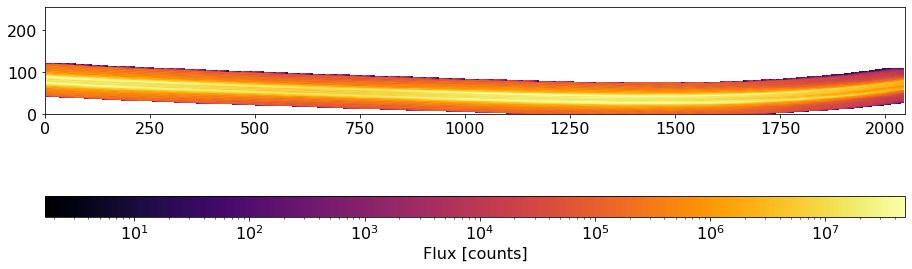

In [6]:
plt.subplot(111, aspect='equal')

plt.pcolormesh(model_image_order1, norm=LogNorm())

cb = plt.colorbar(orientation='horizontal', aspect=40)
cb.set_label('Flux [counts]')

plt.tight_layout()

Let's do the same for order 2.

In [7]:
sim_order2 = overlap.TrpzOverlap([spatprof_order2], [wavelength_order2], lam_grid=wavelength_sim, orders=[2], thresh=1e-8, c_kwargs={'thresh':1e-6})
model_image_order2 = sim_order2.rebuild(true_flux_sim)

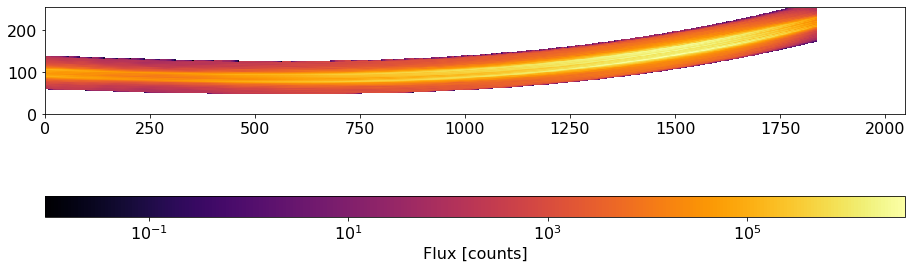

In [8]:
plt.subplot(111, aspect='equal')

plt.pcolormesh(model_image_order2, norm=LogNorm())

cb = plt.colorbar(orientation='horizontal', aspect=40)
cb.set_label('Flux [counts]')

plt.tight_layout()

Finally let's simulate an image with both orders...

In [9]:
sim_order12 = overlap.TrpzOverlap(spatprof_order12, wavelength_order12, lam_grid=wavelength_sim, orders=[1, 2], thresh=1e-8, c_kwargs={'thresh':1e-6})
model_image_order12 = sim_order12.rebuild(true_flux_sim)

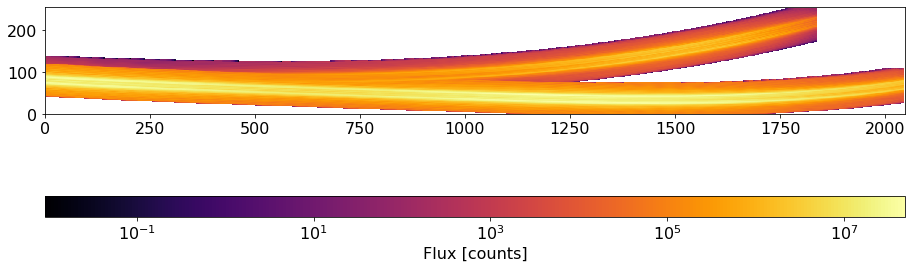

In [10]:
plt.subplot(111, aspect='equal')

plt.pcolormesh(model_image_order12, norm=LogNorm())

cb = plt.colorbar(orientation='horizontal', aspect=40)
cb.set_label('Flux [counts]')

plt.tight_layout()

...and verify that this is the sum of the individual orders.

In [11]:
np.allclose(model_image_order1 + model_image_order2, model_image_order12)  # TODO it's not exactly equal...

False

# Running the extraction on the model images.

To run the extraction we again create an instance of `TrpzOverlap`, for now we only consider order 1.

In [12]:
# TODO I'm using the same wavelength grid for the extraction as I did for the simulation. Is that OK?
extract_order1 = overlap.TrpzOverlap([spatprof_order1], [wavelength_order1], lam_grid=wavelength_sim, orders=[1], thresh=1e-8, c_kwargs={'thresh':1e-6})

To run the extraction we run the `extract` method of `TrpzOverlap` on the model image containing only order 1.

In [13]:
extracted_flux_order1 = extract_order1.extract(data=model_image_order1)

The extracted flux is on the oversampled wavelength grid we used for the extraction, in order to compare it to the true flux we must concolve both down to the same wavelgth grid. This can be done using the `bin_to_pixel` method of `TrpzOverlap`.

In [14]:
# TODO I'm still not entirely clear on what the bin_to_pixel method does.
wavelength_bin, extracted_flux_order1_bin = extract_order1.bin_to_pixel(f_k=extracted_flux_order1)
wavelength_bin, true_flux_order1_bin = extract_order1.bin_to_pixel(f_k=true_flux_sim)

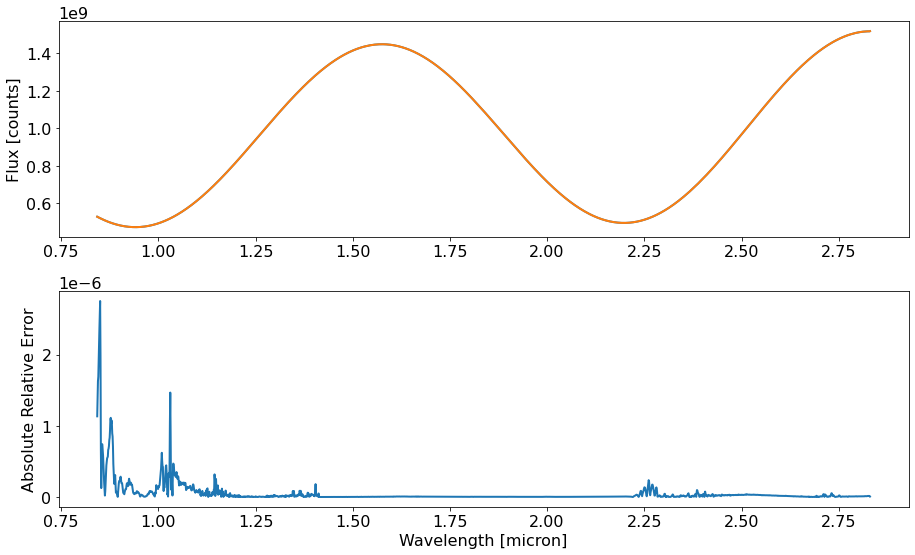

In [15]:
ax = plt.subplot(211)

plt.plot(wavelength_bin, true_flux_order1_bin)
plt.plot(wavelength_bin, extracted_flux_order1_bin)

plt.ylabel('Flux [counts]')

plt.subplot(212, sharex=ax)

plt.plot(wavelength_bin, np.abs((true_flux_order1_bin - extracted_flux_order1_bin)/true_flux_order1_bin))

plt.xlabel('Wavelength [micron]')
plt.ylabel('Absolute Relative Error')

plt.tight_layout()

Of course, if we use this extration on the image containg both order 1 and 2, we will see deviations caused by the contamination of order 1 by order 2...

In [16]:
extracted_flux_order1 = extract_order1.extract(data=model_image_order12)
wavelength_bin, extracted_flux_order1_bin = extract_order1.bin_to_pixel(f_k=extracted_flux_order1)

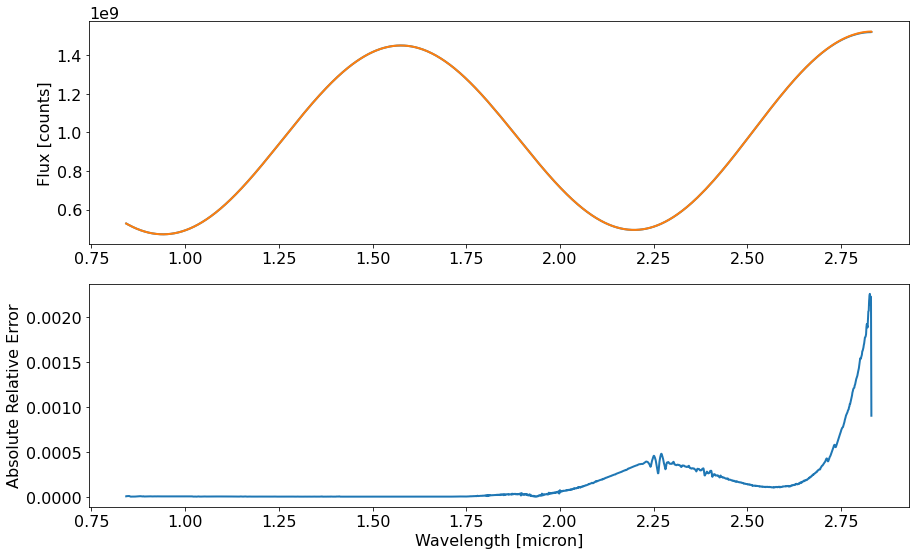

In [17]:
ax = plt.subplot(211)

plt.plot(wavelength_bin, true_flux_order1_bin)
plt.plot(wavelength_bin, extracted_flux_order1_bin)

plt.ylabel('Flux [counts]')

plt.subplot(212, sharex=ax)

plt.plot(wavelength_bin, np.abs((true_flux_order1_bin - extracted_flux_order1_bin)/true_flux_order1_bin))

plt.xlabel('Wavelength [micron]')
plt.ylabel('Absolute Relative Error')

plt.tight_layout()

...and these deviations will be much larger if we try to extract only order 2 from the model image containing order 1 and order 2.

In [18]:
extract_order2 = overlap.TrpzOverlap([spatprof_order2], [wavelength_order2], lam_grid=wavelength_sim, orders=[2], thresh=1e-8, c_kwargs={'thresh':1e-6})

extracted_flux_order2 = extract_order2.extract(data=model_image_order12)

wavelength_bin, extracted_flux_order2_bin = extract_order2.bin_to_pixel(f_k=extracted_flux_order2)
wavelength_bin, true_flux_order2_bin = extract_order2.bin_to_pixel(f_k=true_flux_sim)

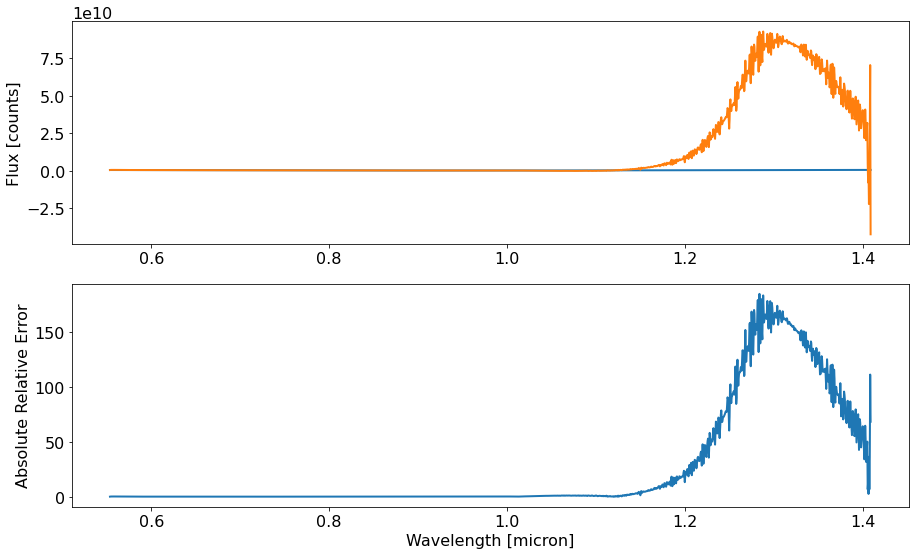

In [19]:
ax = plt.subplot(211)

plt.plot(wavelength_bin, true_flux_order2_bin)
plt.plot(wavelength_bin, extracted_flux_order2_bin)

plt.ylabel('Flux [counts]')

plt.subplot(212, sharex=ax)

plt.plot(wavelength_bin, np.abs((true_flux_order2_bin - extracted_flux_order2_bin)/true_flux_order2_bin))

plt.xlabel('Wavelength [micron]')
plt.ylabel('Absolute Relative Error')

plt.tight_layout()

Finally let's run an extraction that accounts for both order 1 and order 2 on the model image that contains both orders.

In [20]:
extract_order12 = overlap.TrpzOverlap(spatprof_order12, wavelength_order12, lam_grid=wavelength_sim, orders=[1, 2], thresh=1e-8, c_kwargs={'thresh':1e-6})

extracted_flux_order12 = extract_order12.extract(data=model_image_order12)

wavelength_bin, extracted_flux_order12_bin = extract_order12.bin_to_pixel(f_k=extracted_flux_order12)
wavelength_bin, true_flux_order12_bin = extract_order12.bin_to_pixel(f_k=true_flux_sim)

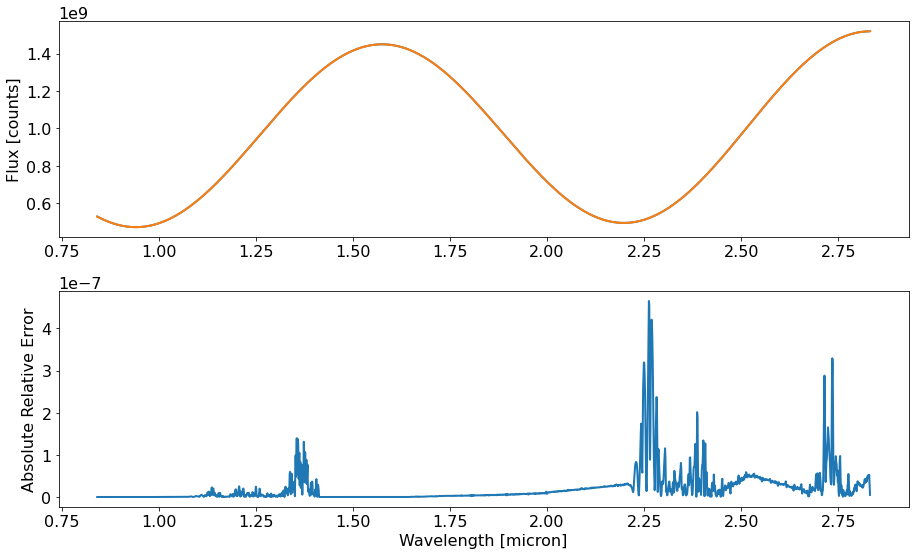

In [21]:
ax = plt.subplot(211)

plt.plot(wavelength_bin, true_flux_order12_bin)
plt.plot(wavelength_bin, extracted_flux_order12_bin)

plt.ylabel('Flux [counts]')

plt.subplot(212, sharex=ax)

plt.plot(wavelength_bin, np.abs((true_flux_order12_bin - extracted_flux_order12_bin)/true_flux_order12_bin))

plt.xlabel('Wavelength [micron]')
plt.ylabel('Absolute Relative Error')

plt.tight_layout()